<a href="https://colab.research.google.com/github/maoramirez69/14MBID/blob/main/2_Modelo_Chagas_diana2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# instalar versión específica de itsdangerous para evitar conflictos
!pip install -U itsdangerous
#!pip install itsdangerous#==2.1.2
!pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


# **IMPORTAR LIBRERÍAS**

In [3]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings 
import re
import io
import matplotlib.cm as cm
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from numpy import corrcoef, transpose, arange
from IPython.display import Image
import statsmodels.api as sm
from scipy import stats
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from google.colab import data_table
data_table.disable_dataframe_formatter()

# **SET DATOS A UTILIZAR: ChEMBL**
Se utilizarán datos recuperados de la base de datos ChEMBL. Para más información ver [*Base de Datos de ChEMBL*](https://www.ebi.ac.uk/chembl/)

Se busca en objetivos o 'targets' la primera enfermedad, en este caso será chagas desde ChEMBL [*Query chagas desde ChEMBL*](https://www.ebi.ac.uk/chembl/g/#search_results/targets/query=lymphoma)


In [19]:
chagas_trg = new_client.target
chagas_trgt_query = chagas_trg.search('trypanosoma') #DIANA 1
# Convertir a dataframe
chagas_trgs = pd.DataFrame.from_dict(chagas_trgt_query)
#Visualizar el dataframe
chagas_trgs

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Trypanosoma,Trypanosoma,16.0,True,CHEMBL612883,[],ORGANISM,5690
1,[],Trypanosoma brucei,Trypanosoma brucei,14.0,False,CHEMBL612849,[],ORGANISM,5691
2,[],Trypanosoma cruzi,Trypanosoma cruzi,14.0,False,CHEMBL368,[],ORGANISM,5693
3,[],Trypanosoma evansi,Trypanosoma evansi,14.0,False,CHEMBL1075362,[],ORGANISM,5697
4,[],Trypanosoma lewisi,Trypanosoma lewisi,14.0,False,CHEMBL2366781,[],ORGANISM,5695
...,...,...,...,...,...,...,...,...,...
69,[],Trypanosoma cruzi,Phosphodiesterase,7.0,False,CHEMBL4523319,"[{'accession': 'Q53I60', 'component_descriptio...",SINGLE PROTEIN,5693
70,[],Trypanosoma cruzi (strain CL Brener),Histidine--tRNA ligase,7.0,False,CHEMBL4662925,"[{'accession': 'Q4DA54', 'component_descriptio...",SINGLE PROTEIN,353153
71,[],Trypanosoma cruzi (strain CL Brener),"Tyrosyl-tRNA synthetase, putative",7.0,False,CHEMBL4662926,"[{'accession': 'Q4DSP6', 'component_descriptio...",SINGLE PROTEIN,353153
72,[],Trypanosoma cruzi,Proteasome subunit beta,7.0,False,CHEMBL4662930,"[{'accession': 'O96673', 'component_descriptio...",SINGLE PROTEIN,5693


In [20]:
#Calcular el tamaño del dataframe
print('Total registros: ', chagas_trgs.size, ' Dimension: ', chagas_trgs.shape)

Total registros:  666  Dimension:  (74, 9)


Se asigna la tercera entrada (que corresponde a la enfermedad objetivo) a la variable ***selected_target***, probando las 2 primeras entradas sin resultado asociados

In [21]:
chembl_trg = chagas_trgs.target_chembl_id[2]  #chagas_trgs.target_chembl_id[5]
chembl_trg

'CHEMBL368'

Es necesario filtrar la información para que solo recupere datos con bioactividad IC50 para la primera enfermedad **target_chembl_id = 'CHEMBL368'** que se muestran como valor de pChEMBL con valores de IC50

In [22]:
activity = new_client.activity
res_ic50 = activity.filter(target_chembl_id = chembl_trg).filter(standard_type="IC50")

Se convierte el array **res_ic50** resultado del comando anterior  en *DataFrame* de Pandas.

In [23]:
df = pd.DataFrame.from_dict(res_ic50) #20 mins

In [24]:
#df = pd.read_csv('chagas_diana_1.csv', sep = ',')
df.shape

(14531, 45)

In [25]:
#molecule_chembl_id	canonical_smiles	standard_value
df['standard_value']

0        70000.0
1           None
2        70000.0
3        65800.0
4        70000.0
          ...   
14526       61.0
14527      140.0
14528       52.0
14529      340.0
14530      630.0
Name: standard_value, Length: 14531, dtype: object

In [26]:
#eliminar variables tipo objeto con for excepto molecule_chembl_id y canonical_smiles
for col in df.columns:
    if df[col].dtype == 'object':
        if col != 'molecule_chembl_id' and col != 'canonical_smiles' and col != 'standard_value':
            df.drop(col, axis=1, inplace=True)

## Matriz de correlación

<ipython-input-27-5d7e73fb5297>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


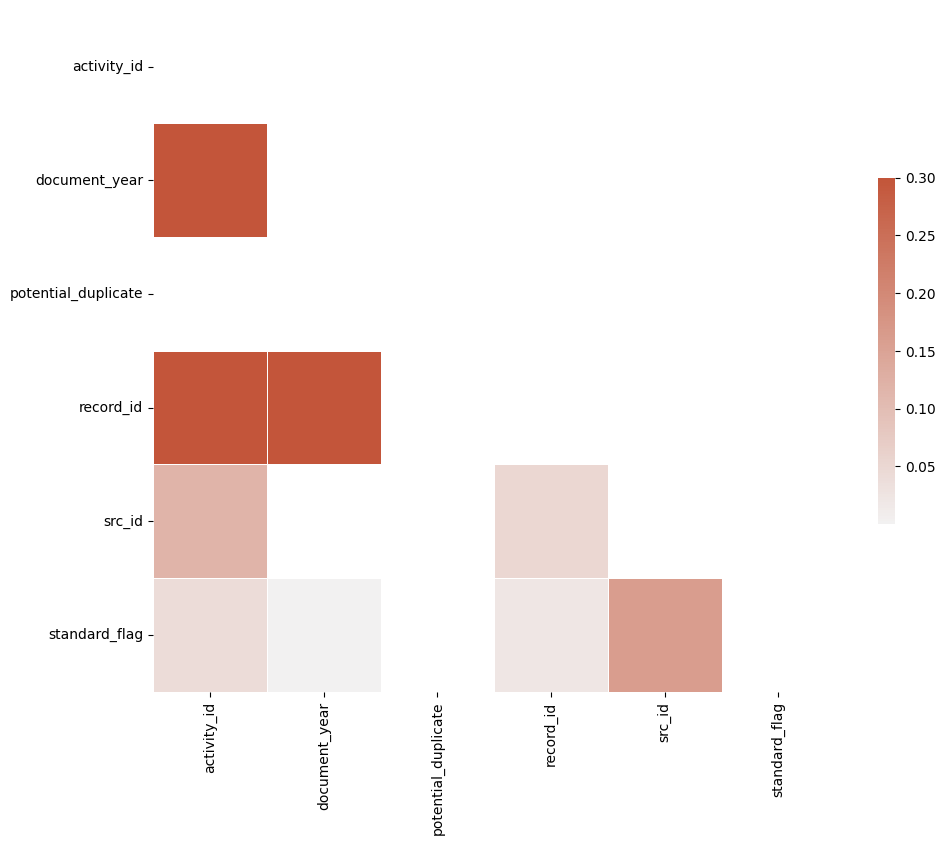

In [27]:
# crear matriz de correlación
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
#ver figura generada


# **Proceso KDD**
Se eliminan registros vacíos en la columna **standard_value** y **canonical_smiles**.

In [28]:
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df.shape

(13682, 9)

Se verifica la cantidad de registros únicos y luego se eliminan los duplicados

In [29]:
len(df.canonical_smiles.unique())
df2_kdd = df.drop_duplicates(['canonical_smiles'])
df2_kdd

,activity_id,canonical_smiles,document_year,molecule_chembl_id,potential_duplicate,record_id,src_id,standard_flag,standard_value
0,149705,CCCCCC(P(=O)(O)O)P(=O)(O)O,2003.0,CHEMBL280463,0,207032,1,1,70000.0
2,150914,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,2003.0,CHEMBL110971,0,207043,1,1,70000.0
4,150917,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,2003.0,CHEMBL109374,0,207027,1,1,70000.0
6,154598,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,2003.0,CHEMBL109948,0,207029,1,1,50000.0
8,155815,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,2003.0,CHEMBL111392,0,207037,1,1,70000.0
...,...,...,...,...,...,...,...,...,...
14524,24372567,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,2021.0,CHEMBL4740928,0,3775827,1,1,180.0
14525,24372568,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,2021.0,CHEMBL5085151,0,3775828,1,1,150.0
14528,24372571,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,2021.0,CHEMBL5073339,0,3775823,1,1,52.0
14529,24372572,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,2021.0,CHEMBL5077758,0,3775824,1,1,340.0


## Eliminar variables que no aportan al modelo

In [30]:
# dejar solo las variables molecule_chembl_id canonical_smiles y standard_value
df2_kdd = df2_kdd[['molecule_chembl_id', 'canonical_smiles', 'standard_value']]
df2_kdd

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0
6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0
8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
...,...,...,...
14524,CHEMBL4740928,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,180.0
14525,CHEMBL5085151,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,150.0
14528,CHEMBL5073339,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,52.0
14529,CHEMBL5077758,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,340.0


## Imputar valores faltantes
Imputar valores faltantes en standard_value con valor minimo

In [31]:
df2_kdd['standard_value'] = df2_kdd['standard_value'].fillna(df2_kdd['standard_value'].min())
df2_kdd

<ipython-input-31-ce26de40612d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_kdd['standard_value'] = df2_kdd['standard_value'].fillna(df2_kdd['standard_value'].min())


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0
6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0
8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
...,...,...,...
14524,CHEMBL4740928,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,180.0
14525,CHEMBL5085151,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,150.0
14528,CHEMBL5073339,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,52.0
14529,CHEMBL5077758,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,340.0


## Validar moléculas con REGEX

In [32]:
# crear expresión regular para validar smiles
pattern = re.compile('^(?:\[.*?\]|[A-Za-z0-9@%+\-=\(\)\[\]\{\}\.\#\$\*\^\~\?\!\/\\\:]+)$')
# crear función para validar smiles
def valid_smiles(smiles):
    if pattern.match(smiles):
        return True
    else:
        return False
    
# crear nueva columna con resultado de validación
df2_kdd['is_valid'] = df2_kdd['canonical_smiles'].apply(valid_smiles)

<ipython-input-32-e970c23ece14>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_kdd['is_valid'] = df2_kdd['canonical_smiles'].apply(valid_smiles)


In [33]:
df2_kdd.head(3)

,molecule_chembl_id,canonical_smiles,standard_value,is_valid
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,True
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,True


In [34]:
#eliminar registros con smiles no validos
df2_kdd = df2_kdd[df2_kdd.is_valid == True]
df2_kdd

,molecule_chembl_id,canonical_smiles,standard_value,is_valid
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,True
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,True
6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0,True
8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True
...,...,...,...,...
14524,CHEMBL4740928,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,180.0,True
14525,CHEMBL5085151,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,150.0,True
14528,CHEMBL5073339,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,52.0,True
14529,CHEMBL5077758,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,340.0,True


Ejemplo de verificación de diagrama de la segunda molécula

In [36]:
!pip install rdkit
from rdkit import Chem
molecula_0 = Chem.MolFromSmiles(df2_kdd['canonical_smiles'][0])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 19.9 MB/s eta 0:00:00


In [37]:
print(df2_kdd['canonical_smiles'][2])
#dibujar molecula .png
from rdkit.Chem import Draw
Draw.MolToFile(molecula_0, 'molecula_0.png')
#guardar molecula .png
from IPython.display import Image
#Image(filename='molecula_0.png')

CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O


In [38]:
# Resetear índices
df2_kdd = df2_kdd.reset_index()
df2_kdd.to_csv('chagas_d1_02_bioactividad_preprocesado.csv', index=False)

# **Categorizar compuestos**
Los datos de bioactividad, consignados en la columna standard_value, están en unidades de IC50. Se clasifican estos valores en tres categorías. Los compuestos que tengan valores inferiores a 1.000 nM se considerarán **‘activos’**, Los valores entre 1.000 nM y 10.000 nM tendrán una categoría **‘NaN’** debido a que no se utilizarán, mientras que los valores superiores a 10.000 nM se considerarán **‘inactivos**’.

In [42]:
import numpy as np

df2_kdd['valor_bioactividad'] = ''
df2_kdd['valor_bioactividad'] = np.where(df2_kdd['standard_value'].astype(float) >= 10000, 'inactivo', np.where(df2_kdd['standard_value'].astype(float) <= 1000, 'activo','NA' ))
df2_kdd = df2_kdd[(df2_kdd.valor_bioactividad == 'activo') | (df2_kdd.valor_bioactividad == 'inactivo')]
#reemplazar ceros con valor más pequeño
df2_kdd['standard_value'] = df2_kdd['standard_value'].replace(0.0, 0.06)
df2_kdd = df2_kdd.reset_index()
df2_kdd
#df4.drop(columns=['rango'])

<ipython-input-42-e2507fe0eb10>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_kdd['standard_value'] = df2_kdd['standard_value'].replace(0.0, 0.06)


,level_0,index,molecule_chembl_id,canonical_smiles,standard_value,is_valid,valor_bioactividad
0,0,0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True,inactivo
1,1,2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,True,inactivo
2,2,4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,True,inactivo
3,3,6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0,True,inactivo
4,4,8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True,inactivo
...,...,...,...,...,...,...,...
7074,8750,14524,CHEMBL4740928,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,180.0,True,activo
7075,8751,14525,CHEMBL5085151,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,150.0,True,activo
7076,8752,14528,CHEMBL5073339,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,52.0,True,activo
7077,8753,14529,CHEMBL5077758,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,340.0,True,activo


In [43]:
#eliminar columna index y is_valid
df2_kdd = df2_kdd.drop(columns=['index', 'is_valid'])
df2_kdd

,level_0,molecule_chembl_id,canonical_smiles,standard_value,valor_bioactividad
0,0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,inactivo
1,1,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,inactivo
2,2,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,inactivo
3,3,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0,inactivo
4,4,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,inactivo
...,...,...,...,...,...
7074,8750,CHEMBL4740928,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,180.0,activo
7075,8751,CHEMBL5085151,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,150.0,activo
7076,8752,CHEMBL5073339,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,52.0,activo
7077,8753,CHEMBL5077758,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,340.0,activo


### Entorno virtual

In [44]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys

--2023-05-28 17:26:43--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   136MB/s    in 0.6s    

2023-05-28 17:26:44 (136 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

### Separar datasets

In [45]:
df_no_smiles = df2_kdd.drop(columns='canonical_smiles')

smiles = []

for i in df2_kdd.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [46]:
# segundo dataframe
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)
df_clean_smiles

,level_0,molecule_chembl_id,standard_value,valor_bioactividad,canonical_smiles
0,0,CHEMBL280463,70000.0,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O
1,1,CHEMBL110971,70000.0,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O
2,2,CHEMBL109374,70000.0,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC
3,3,CHEMBL109948,50000.0,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC
4,4,CHEMBL111392,70000.0,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...
7074,8750,CHEMBL4740928,180.0,activo,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1
7075,8751,CHEMBL5085151,150.0,activo,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...
7076,8752,CHEMBL5073339,52.0,activo,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...
7077,8753,CHEMBL5077758,340.0,activo,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...


# **Calcular descriptores de Lipinski**
Christopher Lipinski, un científico de Pfizer, ideó un conjunto de reglas empíricas para evaluar la similitud de los compuestos con las drogas. Tal semejanza con las drogas se basa en la Absorción, Distribución, Metabolismo y Excreción (ADME), que también se conoce como perfil farmacocinético. Lipinski analizó todos los medicamentos activos por vía oral aprobados por la FDA en la formulación de lo que se conocerá como la regla de los cinco o la regla de Lipinski.

La Regla de Lipinski establecía lo siguiente:

Peso molecular < 500 Dalton
Coeficiente de reparto octanol-agua (LogP) < 5
Donantes de enlaces de hidrógeno < 5
Aceptores de enlaces de hidrógeno < 10

In [48]:
"""
Lipinski:
    Peso Molecular          <= 500
    LogP                    <= 5
    Donadores de Hidrógeno  <= 5
    Aceptores de Hidrógeno  <= 10
"""
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [49]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["Peso_Molecular","LogP","Num_Donadores_H","Num_Aceptores"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df_lipinski = lipinski(df2_kdd.canonical_smiles)
#convertir Num_Donadores_H y Num_Aceptores a enteros
df_lipinski[['Num_Donadores_H', 'Num_Aceptores']] = df_lipinski[['Num_Donadores_H', 'Num_Aceptores']].astype(int)
df_lipinski

,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores
0,246.136,1.2482,4,2
1,304.216,1.7385,5,3
2,330.298,4.6448,0,6
3,386.406,6.2052,0,6
4,302.244,2.8086,4,2
...,...,...,...,...
7074,323.736,3.0649,0,6
7075,357.288,3.4303,0,6
7076,373.287,3.3101,0,7
7077,373.287,3.3101,0,7


### **Unión de datasets**
Se unen los datasets con descriptores de Lipinski

In [50]:
df_combined = pd.concat([df_clean_smiles ,df_lipinski], axis=1)
df_combined

,level_0,molecule_chembl_id,standard_value,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores
0,0,CHEMBL280463,70000.0,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O,246.136,1.2482,4,2
1,1,CHEMBL110971,70000.0,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,304.216,1.7385,5,3
2,2,CHEMBL109374,70000.0,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,330.298,4.6448,0,6
3,3,CHEMBL109948,50000.0,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,386.406,6.2052,0,6
4,4,CHEMBL111392,70000.0,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,302.244,2.8086,4,2
...,...,...,...,...,...,...,...,...,...
7074,8750,CHEMBL4740928,180.0,activo,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,323.736,3.0649,0,6
7075,8751,CHEMBL5085151,150.0,activo,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,357.288,3.4303,0,6
7076,8752,CHEMBL5073339,52.0,activo,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,373.287,3.3101,0,7
7077,8753,CHEMBL5077758,340.0,activo,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,373.287,3.3101,0,7


## **Convertir IC50 a pIC50**
Para permitir que los datos de **IC50** se distribuyan de manera más uniforme, convertiremos **IC50** a la escala logarítmica negativa que es esencialmente **-log10(IC50)**.

Esta función pIC50() recibe el dataset como parámetro de entrada.
* Toma el valor de IC50 desde la columna ``standard_value`` y la convierte desde nM a M y luego multiplica el valor por 10$^{-9}$
* Toma el valor molar y luego aplica el -log10
* Se borra la columna ``standard_value`` y se reemplaza por la columna ``pIC50``

In [51]:
df_combined.standard_value.describe()

count        7079
unique       2751
top       32000.0
freq          239
Name: standard_value, dtype: object

### Establecer cotas de valores
Los valores superiores a 100 000 000 se fijarán en 100 000 000; de lo contrario, el valor logarítmico negativo se volverá negativo.

In [52]:
-np.log10( (10**-9)* 100000000 )
-np.log10( (10**-9)* 100000000 )

1.0

### Normalizar valores pIC50

In [54]:
def normalizar_pic50(input):
    norm = []

    for i in input['standard_value'].astype(float):
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_pic50'] = norm
    x = input.drop('standard_value', 1)
        
    return x

df_pic50 = normalizar_pic50(df_combined)
df_pic50

<ipython-input-54-e8919c8fc18d>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


,level_0,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,standard_value_pic50
0,0,CHEMBL280463,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O,246.136,1.2482,4,2,70000.0
1,1,CHEMBL110971,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,304.216,1.7385,5,3,70000.0
2,2,CHEMBL109374,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,330.298,4.6448,0,6,70000.0
3,3,CHEMBL109948,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,386.406,6.2052,0,6,50000.0
4,4,CHEMBL111392,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,302.244,2.8086,4,2,70000.0
...,...,...,...,...,...,...,...,...,...
7074,8750,CHEMBL4740928,activo,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,323.736,3.0649,0,6,180.0
7075,8751,CHEMBL5085151,activo,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,357.288,3.4303,0,6,150.0
7076,8752,CHEMBL5073339,activo,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,373.287,3.3101,0,7,52.0
7077,8753,CHEMBL5077758,activo,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,373.287,3.3101,0,7,340.0


In [55]:
df_pic50 = df_pic50.drop(columns = {'level_0'})

In [56]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_pic50']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_pic50', 1)
        
    return x

df_final = pIC50(df_pic50)
df_final

<ipython-input-56-98f6a29b0c48>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_pic50', 1)


,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL280463,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O,246.136,1.2482,4,2,4.154902
1,CHEMBL110971,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,304.216,1.7385,5,3,4.154902
2,CHEMBL109374,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,330.298,4.6448,0,6,4.154902
3,CHEMBL109948,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,386.406,6.2052,0,6,4.301030
4,CHEMBL111392,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,302.244,2.8086,4,2,4.154902
...,...,...,...,...,...,...,...,...
7074,CHEMBL4740928,activo,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,323.736,3.0649,0,6,6.744727
7075,CHEMBL5085151,activo,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,357.288,3.4303,0,6,6.823909
7076,CHEMBL5073339,activo,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,373.287,3.3101,0,7,7.283997
7077,CHEMBL5077758,activo,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,373.287,3.3101,0,7,6.468521


In [85]:
df_final.to_csv('chagas_d1_04_bioactividad_data_3class_pIC50.csv')
df_final = pd.read_csv('chagas_d1_04_bioactividad_data_3class_pIC50.csv')

### **Eliminar valores NaN de la columna valor_bioactividad**
Aquí, eliminaremos el valor ``NaN`` de nuestro conjunto de datos.

In [86]:
df2 = df_final.dropna()
df2.reset_index()
df2
#df2.to_csv('chagas_05_bioactivity_data_2class_pIC50.csv')

,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,0,0,CHEMBL280463,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O,246.136,1.2482,4,2,4.154902
1,1,1,CHEMBL110971,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,304.216,1.7385,5,3,4.154902
2,2,2,CHEMBL109374,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,330.298,4.6448,0,6,4.154902
3,3,3,CHEMBL109948,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,386.406,6.2052,0,6,4.301030
4,4,4,CHEMBL111392,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,302.244,2.8086,4,2,4.154902
...,...,...,...,...,...,...,...,...,...,...
7074,7074,7074,CHEMBL4740928,activo,CC1(COc2ccc(Cl)cc2)CCn2cc([N+](=O)[O-])nc2O1,323.736,3.0649,0,6,6.744727
7075,7075,7075,CHEMBL5085151,activo,CC1(COc2ccc(C(F)(F)F)cc2)CCn2cc([N+](=O)[O-])n...,357.288,3.4303,0,6,6.823909
7076,7076,7076,CHEMBL5073339,activo,C[C@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[O...,373.287,3.3101,0,7,7.283997
7077,7077,7077,CHEMBL5077758,activo,C[C@@]1(COc2ccc(OC(F)(F)F)cc2)CCn2cc([N+](=O)[...,373.287,3.3101,0,7,6.468521


In [87]:
df2 = df2.drop(columns = {'Unnamed: 0', 'Unnamed: 0.1'})

In [88]:
#leer csv
import pandas as pd
from pandas import read_csv
#df2 = read_csv('chagas_05_bioactivity_data_2class_pIC50.csv', sep=',')

## **Análisis de datos exploratorios (Análisis del espacio químico) a través del descriptor de Lipinski**

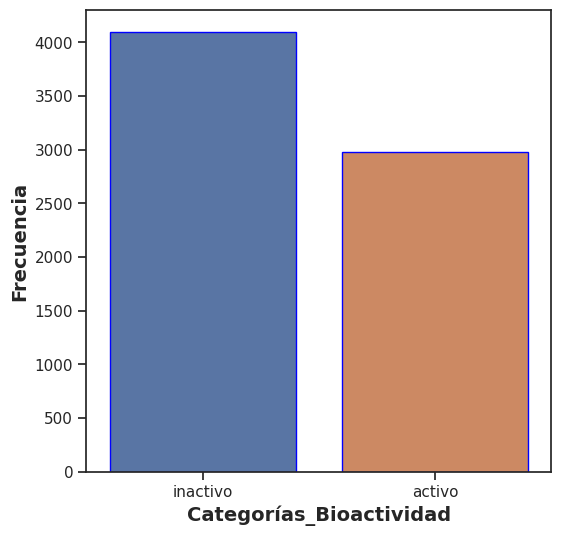

In [89]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt


### **Diagrama de frecuencias para las dos categorías**
#dibujar grafica .png
plt.figure(figsize=(6, 6))
#calbiar colores de barras a morado y amarillo
sns.countplot(x='valor_bioactividad', data=df2, edgecolor='blue') #facecolor='blue'
#sns.countplot(x='valor_bioactividad', data=df2, palette = 'hls', edgecolor = 'black')
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=14, fontweight='bold')
#cambiar colores de la grafica
sns.set_palette("pastel")

Text(0, 0.5, 'Categorías_Bioactividad')

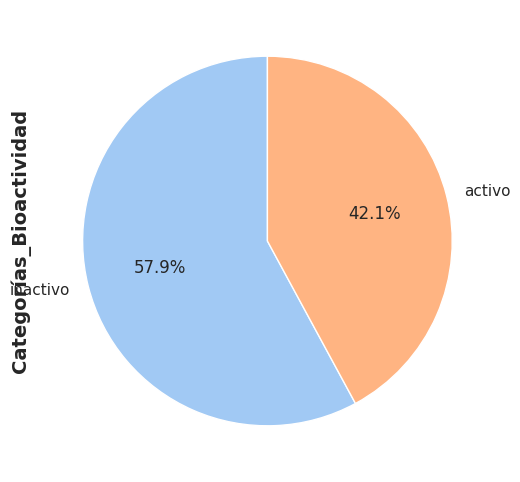

In [90]:
#Se construye un pie chart para visualizar la distribución de las dos clases
plt.figure(figsize=(6,6))
#se cambia el color de las barras a morado y amarillo
sns.set_palette("pastel")
#se dibuja el pie chart
df2.valor_bioactividad.value_counts().plot.pie(autopct='%1.1f%%', shadow=False, explode=(0.0,0), startangle=90)
#rotar el pie chart 10 grados
plt.xticks(rotation=90)
#contorno de la grafica azul
plt.rcParams['patch.edgecolor'] = 'blue'
plt.ylabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
# plt.savefig('pie_chart_categorias_bioactividad.png')
# #guardar pie chart .png
# Image(filename='pie_chart_categorias_bioactividad.png')

### Equilibar Clases

In [91]:
#equilibrar las clases
df2.valor_bioactividad.value_counts()

#seleccionar las clases con 2500 elementos aleatorios
df2_activo = df2[df2.valor_bioactividad == 'activo']#.sample(2500)
df2_inactivo = df2[df2.valor_bioactividad == 'inactivo']#.sample(2500)

#concatenar los dos dataframes
df2 = pd.concat([df2_activo, df2_inactivo], axis=0)
df2 = df2.reset_index(drop=True)
df2

,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL117926,activo,COc1ccc2c(c1)cc1c3cc(C#N)ccc3nc-1n2C,287.322,3.71158,0,4,6.000000
1,CHEMBL118915,activo,COc1ccc2c(c1)N(C)C1Nc3ccccc3C1=C2,264.328,3.43720,1,3,6.000000
2,CHEMBL304666,activo,CSc1cc(-c2ccc(-c3ccc(/N=C(\N)c4ccccn4)c(SC)c3)...,550.713,6.92140,2,7,6.823909
3,CHEMBL416108,activo,Cc1cc(NC(=N)c2ccccn2)ccc1-c1ccc(-c2ccc(NC(=N)c...,486.579,6.89538,4,5,6.677781
4,CHEMBL48856,activo,N=C(Nc1ccc(-c2ccc(-c3ccc(NC(=N)c4ccccn4)cc3Cl)...,527.415,7.58534,4,5,6.309804
...,...,...,...,...,...,...,...,...
7074,CHEMBL5093839,inactivo,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,304.430,2.85160,2,3,4.441651
7075,CHEMBL5079196,inactivo,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O[N+](=O)[O...,394.424,3.28360,0,7,4.316053
7076,CHEMBL5083602,inactivo,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O[N+](=O)[O...,380.441,4.10300,0,6,3.459796
7077,CHEMBL5076723,inactivo,CC1(COc2ncc(F)cn2)CCn2cc([N+](=O)[O-])nc2O1,309.257,1.34060,0,8,4.853872


### **Diagrama de puntos Peso_Molecular vs LogP**
Puede verse que las 2 categorías de bioactividad abarcan espacios químicos similares, como lo demuestra el diagrama de dispersión de Peso_Molecular frente a LogP.

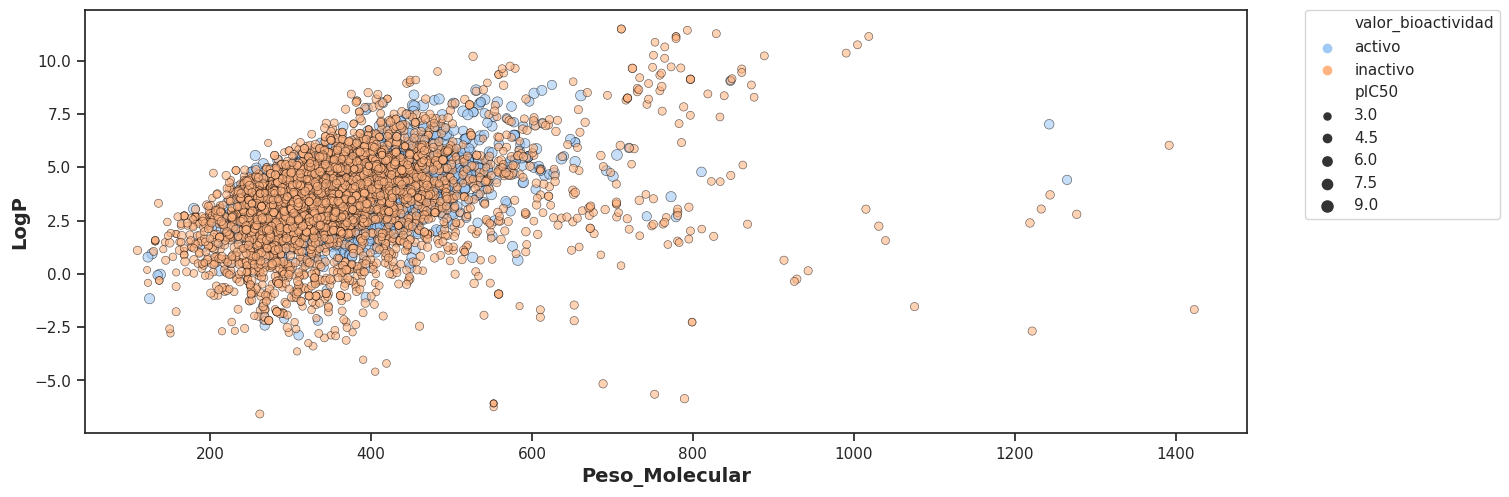

In [92]:
plt.figure(figsize=(15, 5.5))
sns.scatterplot(x='Peso_Molecular', y='LogP', data=df2, hue='valor_bioactividad', size='pIC50', edgecolor='black', alpha=0.6, facecolor = 'red')
plt.xlabel('Peso_Molecular', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.savefig('plot_Peso_Molecular_vs_LogP.png')
# #guardar gráfica .png
# Image(filename='plot_Peso_Molecular_vs_LogP.png')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


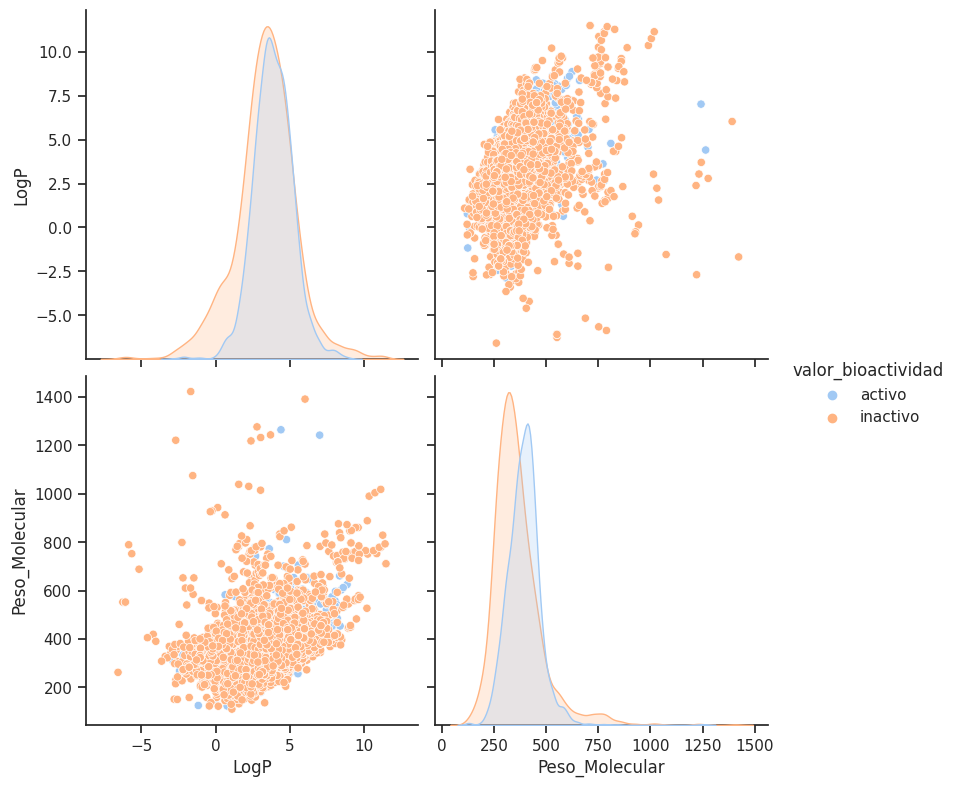

In [93]:
sb.pairplot(df2.dropna(),hue='valor_bioactividad',size=4,vars=["LogP","Peso_Molecular"],kind="scatter")
#guardar gráfica .png
# plt.savefig('plot_Peso_Molecular_vs_LogP_1.png')
# Image(filename='plot_Peso_Molecular_vs_LogP_1.png')

### Box plots descriptores de Lipinski

In [94]:
# crear dos dataframes, uno para cada clase
df_2_activo = df2[df2['valor_bioactividad']=='activo']
df_2_inactivo = df2[df2['valor_bioactividad']=='inactivo']

Text(0, 0.5, 'valor_PIC50')

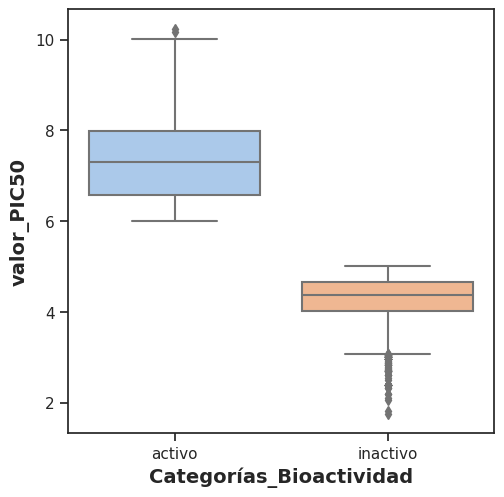

In [95]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'pIC50', data = df2)
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold', )
plt.ylabel('valor_PIC50', fontsize=14, fontweight='bold')
# plt.savefig('plot_ic50.png')
# Image(filename='plot_ic50.png')

Text(0, 0.5, 'Peso_Molecular')

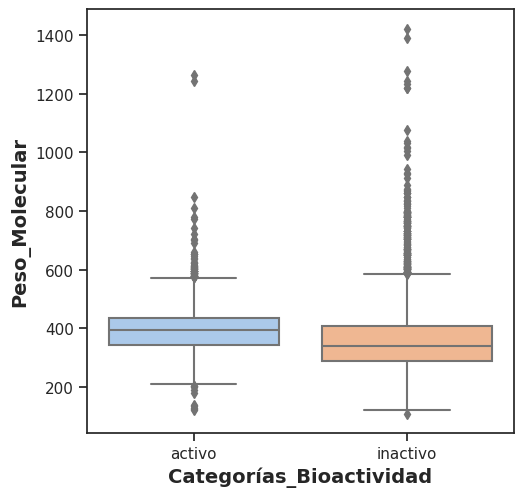

In [96]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'Peso_Molecular', data = df2)
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Peso_Molecular', fontsize=14, fontweight='bold')
# plt.savefig('plot_MW.png')
# Image(filename='plot_MW.png')

Text(0.5, 1.0, 'histogramas para la clase inactivo y activo')

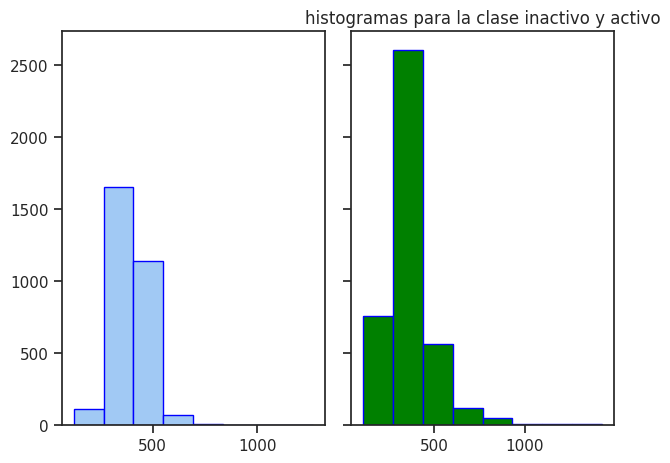

In [97]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Peso_Molecular'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Peso_Molecular'], bins=n_bins,color='green')
plt.title('histogramas para la clase inactivo y activo', loc='center')
# plt.savefig('histograma.png')
# Image(filename='histograma.png')

#### **LogP**

Text(0, 0.5, 'LogP')

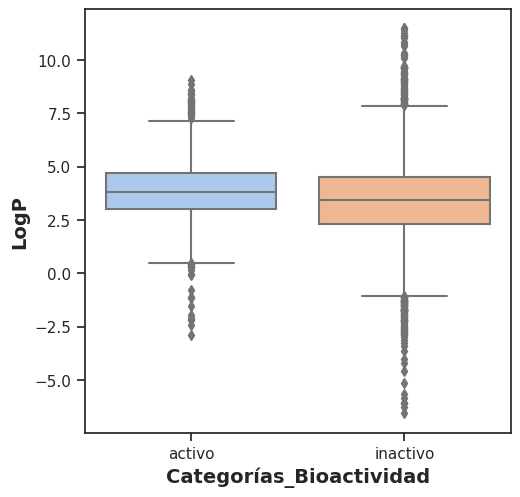

In [98]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'LogP', data = df2)
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
# plt.savefig('plot_LogP.png')
# Image(filename='plot_LogP.png')

Text(0.5, 1.0, 'histogramas para la clase inactivo y activo')

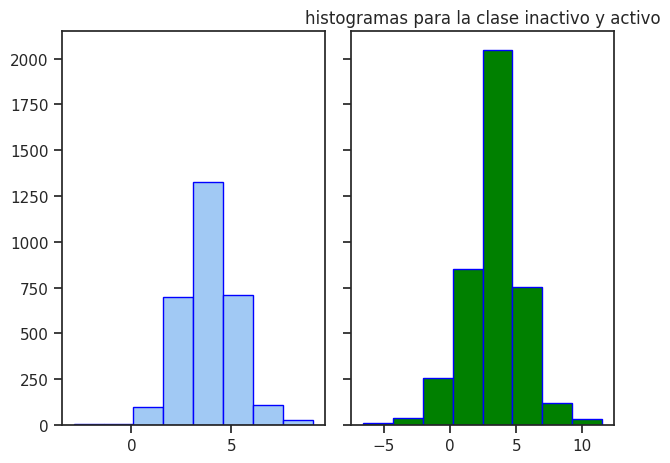

In [99]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['LogP'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['LogP'], bins=n_bins,color='green')
plt.title('histogramas para la clase inactivo y activo')
# plt.savefig('plot_LogP.png')
# Image(filename='plot_LogP.png')

#### **Num_Donadores_Hidrógeno**

Text(0, 0.5, 'Num_Donadores_Hidrógeno')

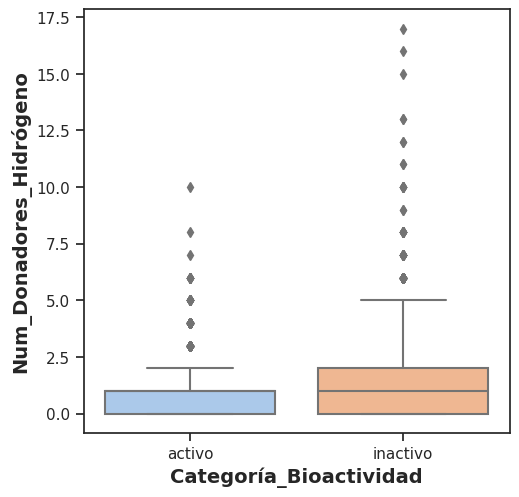

In [100]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'Num_Donadores_H', data = df2)
plt.xlabel('Categoría_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Num_Donadores_Hidrógeno', fontsize=14, fontweight='bold')
# plt.savefig('plot_NumHDonors.png')
# Image(filename='plot_NumHDonors.png')

(array([3.434e+03, 4.100e+02, 2.080e+02, 2.900e+01, 9.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00]),
 array([ 0.   ,  2.125,  4.25 ,  6.375,  8.5  , 10.625, 12.75 , 14.875,
        17.   ]),
 <BarContainer object of 8 artists>)

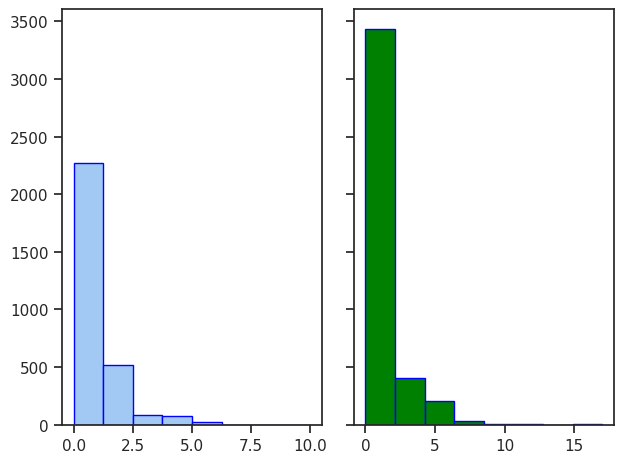

In [101]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Num_Donadores_H'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Num_Donadores_H'], bins=n_bins,color='green')
# plt.savefig('plot_NumHDonors.png')
# Image(filename='plot_NumHDonors.png')

#### **Num_Aceptores**

Text(0, 0.5, 'Numero_Aceptores_Hidrógeno')

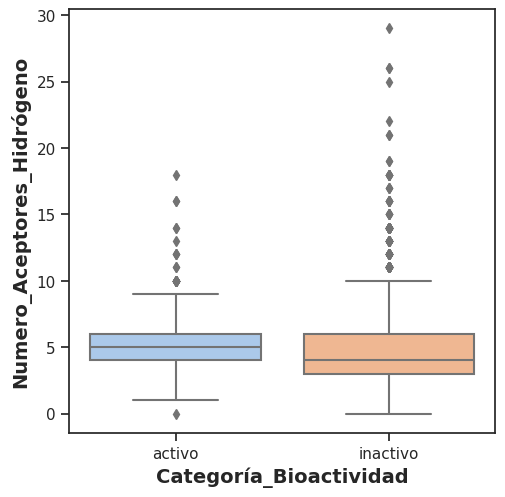

In [102]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'Num_Aceptores', data = df2)
plt.xlabel('Categoría_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Numero_Aceptores_Hidrógeno', fontsize=14, fontweight='bold')
# plt.savefig('plot_NumHAcceptors.png')
# Image(filename='plot_NumHAcceptors.png')

Text(0.5, 1.0, 'histogramas para la clase inactivo y activo')

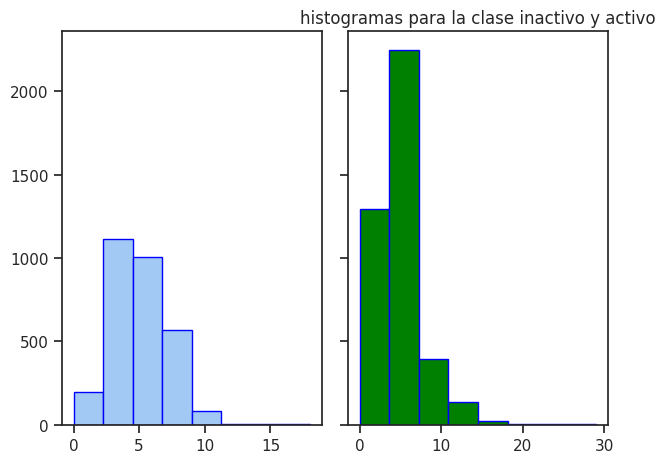

In [103]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Num_Aceptores'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Num_Aceptores'], bins=n_bins,color='green')
plt.title('histogramas para la clase inactivo y activo')
# plt.savefig('plot_NumHAcceptors.png')
# Image(filename='plot_NumHAcceptors.png')

## Crear dataset completo con descriptores por id

In [104]:
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles

mols = []

for i in df2.canonical_smiles:
        mol = MolFromSmiles(i)
        mols.append(mol)
        #print(df2)
ID = df2.molecule_chembl_id
STATUS = df2.valor_bioactividad
MW = [Descriptors.MolWt(n) for n in mols]
LogP = [Descriptors.MolLogP(o) for o in mols]
nHAcc = [Descriptors.NumHAcceptors(p) for p in mols]
nHDon = [Descriptors.NumHDonors(q) for q in mols]

data = pd.DataFrame(
    {'molecule_chembl_id': ID,
     'STATUS' : STATUS,
     'MW': MW, 
     'LogP': LogP,
     'nHAcc': nHAcc,
     'nHDon': nHDon
    })
data = data[['molecule_chembl_id','STATUS','MW','LogP','nHAcc','nHDon']]

In [105]:
data.shape

(7079, 6)

### Distribución de Frecuencias de descriptores

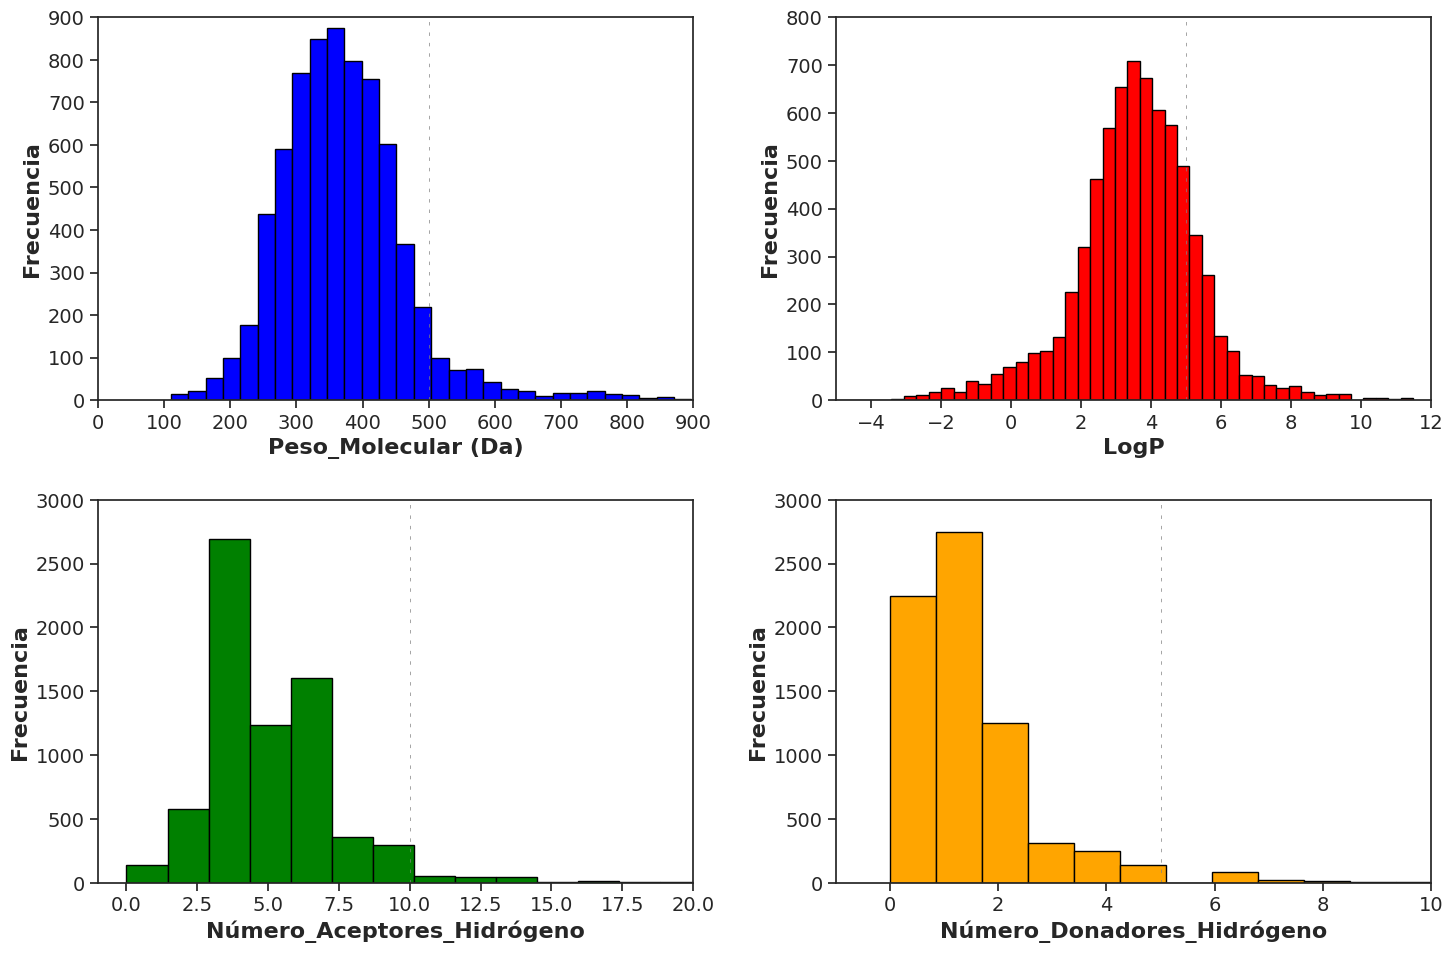

In [106]:
figure, ((plt1,plt2), (plt3,plt4)) = plt.subplots(2, 2)
figure.set_size_inches(15,10)

# Histograma para MW
hist, bins = np.histogram(MW, 50)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt1.bar(center, hist, align='center', width=width, color='blue',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2,linestyle='-', linewidth=0.5))
plt1.set_xlabel('Peso_Molecular (Da)', fontsize=16, fontweight='bold')
plt1.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt1.tick_params(axis='both', which='major', labelsize=14)
plt1.set_xlim(0,900)
plt1.set_ylim(0, 900)
#plt1.grid(True)
plt1.axvline(500, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para LogP
hist, bins = np.histogram(LogP, 50)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt2.bar(center, hist, align='center', width=width, color='red',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2,linestyle='-', linewidth=0.5))
plt2.set_xlabel('LogP', fontsize=16, fontweight='bold')
plt2.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt2.tick_params(axis='both', which='major', labelsize=14)
plt2.set_xlim(-5,12)
plt2.set_ylim(0,800)
plt2.axvline(5, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para Donadores de Hidrógeno
hist, bins = np.histogram(nHDon, 20)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt4.bar(center, hist, align='center', width=width, color='orange',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2, linestyle='-', linewidth=0.5))
plt4.set_xlabel('Número_Donadores_Hidrógeno', fontsize=16, fontweight='bold')
plt4.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt4.tick_params(axis='both', which='major', labelsize=14)
plt4.set_xlim(-1,10)
plt4.set_ylim(0,3000)
#plt4.grid(True)
plt4.axvline(5, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para nHAcc
hist, bins = np.histogram(nHAcc, 20)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt3.bar(center, hist, align='center', width=width, color='green',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2, linestyle='-', linewidth=0.5))
plt3.set_xlabel('Número_Aceptores_Hidrógeno', fontsize=16, fontweight='bold')
plt3.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt3.tick_params(axis='both', which='major', labelsize=14)
plt3.set_xlim(-1,20)
plt3.set_ylim(0,3000)
#plt3.grid(True)
plt3.axvline(10, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
# plt.savefig('plot_descriptores.png')
# Image(filename='plot_descriptores.png')

### Gráficas de densidad para cada medición PIC50 (Estimación Kernel)

<ipython-input-107-fe0e2a937ca1>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_2_activo['pIC50'], rug=True, hist=False,label='PIC50 clase activa',color='blue')
<ipython-input-107-fe0e2a937ca1>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_2_inactivo['pIC50

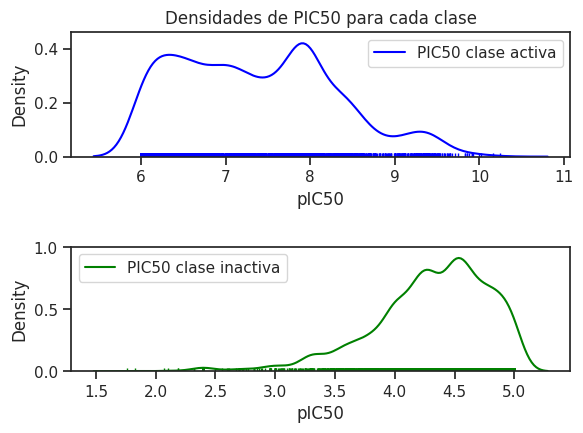

In [107]:
plt.figure()
plt.subplot(2, 1,1)
plt.title('Densidades de PIC50 para cada clase')
ax = sns.distplot(df_2_activo['pIC50'], rug=True, hist=False,label='PIC50 clase activa',color='blue')
plt.legend()
plt.subplot(2, 1,2)
ax = sns.distplot(df_2_inactivo['pIC50'], rug=True, hist=False,label='PIC50 clase inactiva',color='green')
plt.legend()
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
# plt.savefig('densidad_pic50.png')
# Image(filename='densidad_pic50.png')

## Análisis inferencial
En esta sección se van a analizar inferencialmnete  a la variable *PIC50* para la clase activo e inactivo. Por lo tanto, se cargan las siguientes librerías.

Se va a construir los QQ-plot para  'PIC50' en cada una de las  clases
Esto se hace con el objetivo de analizar si los cuantiles teóricos ccoinciden con los cuantiles muestrales 

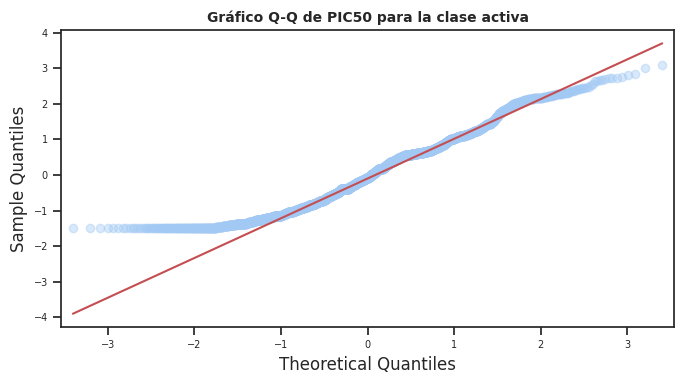

In [108]:
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(df_2_activo['pIC50'],fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de PIC50 para la clase activa', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)
plt.tight_layout()
# plt.savefig('qqplot_activo.png')
# Image(filename='qqplot_activo.png')

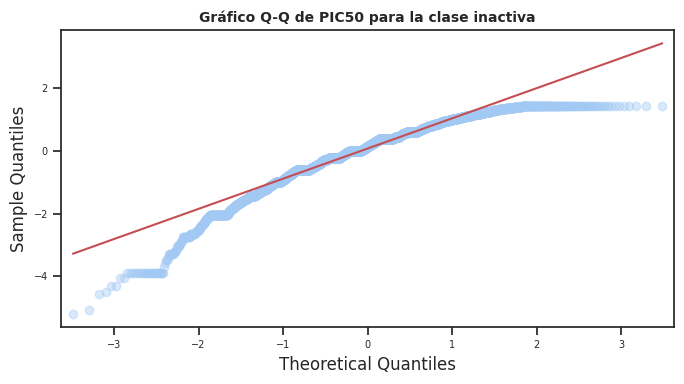

In [109]:
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(df_2_inactivo['pIC50'],fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de PIC50 para la clase inactiva', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)
plt.tight_layout()
# plt.savefig('qqplot_inactivo.png')
# Image(filename='qqplot_inactivo.png')

Se puede apreciar que  empíricamente los cuantiles muestrales de **PIC50** de la clase **inactiva** no se ajustan bien a los cuantiles teóricos de la distribución normal 

## Test de Shapiro-Wilk  (clase activa)

In [ ]:
# ==============================================================================
shapiro_test = stats.shapiro(df_2_activo['pIC50'])
shapiro_test

En este caso el $$p-valor=0.9259*10^{-13}$$ 
Luego, a un nivel de significancia de $$\alpha=0.05$$
Se tiene que: $$p-valor=0.9259*10^{-13}<0.05=\alpha$$
Por lo tanto, se rechaza la hipótesis  nula. Es decir, que como se había apreciada empíricamente la muestra no viene de una población con distribución normal. Por lo tanto, existe evidencia estadística para deducir que la variable **PIC50** de la clase activa no tiene una distribución normal.

## Test de Shapiro-Wilk  (clase inactiva)

In [ ]:
# ==============================================================================
shapiro_test = stats.shapiro(df_2_inactivo['pIC50'])
shapiro_test

En este caso el $$p-valor=0.9449*10^{-14}$$ 
Luego, a un nivel de significancia de $$\alpha=0.05$$
Se tiene que: $$p-valor=0.9449*10^{-14}<0.05=\alpha$$
Por lo tanto, se rechaza la hipótesis  nula. Es decir, que como se había apreciada empíricamente la muestra no viene de una población con distribución normal. Por lo tanto, existe evidencia estadística para deducir que la variable **PIC50** de la clase activa no tiene una distribución normal.

## Test Manwhitney

In [114]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# Establecer semilla
  seed(1)

# Activos e inactivos
  selection = [descriptor, 'valor_bioactividad']
  df = df2[selection]
  activo = df[df['valor_bioactividad'] == 'activo']
  activo = activo[descriptor]

  selection = [descriptor, 'valor_bioactividad']
  df = df2[selection]
  inactivo = df[df['valor_bioactividad'] == 'inactivo']
  inactivo = inactivo[descriptor]

# Comparar muestras
  stat, p = mannwhitneyu(activo, inactivo)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretación de resultados
  alpha = 0.05
  if p > alpha:
    resultado = 'Misma distribución (no rechazar H0)'
  else:
    resultado = 'Diferente distribución (rechazar H0)'
  
  results = pd.DataFrame({'Variable':descriptor,
                          'Resultado':stat,
                          'p-value':p,
                          'alpha':alpha,
                          'Interpretación':resultado}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [115]:
mannwhitney('Peso_Molecular')

,Variable,Resultado,p-value,alpha,Interpretación
0,Peso_Molecular,7892998.0,3.331837e-98,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('LogP')

,Variable,Resultado,p-value,alpha,Interpretación
0,LogP,3668945.0,1.599559e-26,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Num_Donadores_H')

,Variable,Resultado,p-value,alpha,Interpretación
0,Num_Donadores_H,2916156.0,0.000016,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Num_Aceptores')

,Variable,Resultado,p-value,alpha,Interpretación
0,Num_Aceptores,3320148.0,0.000109,0.05,Diferente distribución (rechazar H0)


In [116]:
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2023-05-28 17:47:59--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-05-28 17:48:00--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.1s    

2023-05-28 17:48:01 (204 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2023-05-28 17:48:01--  https://github

In [117]:
#df3 = pd.read_csv('chagas_04_bioactivity_data_3class_pIC50.csv')
#eliminar columnas con 'Uname: 0'
df3 = df2#.drop(columns=['Unnamed: 0'])
df3.head(3)

,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL117926,activo,COc1ccc2c(c1)cc1c3cc(C#N)ccc3nc-1n2C,287.322,3.71158,0,4,6.000000
1,CHEMBL118915,activo,COc1ccc2c(c1)N(C)C1Nc3ccccc3C1=C2,264.328,3.43720,1,3,6.000000
2,CHEMBL304666,activo,CSc1cc(-c2ccc(-c3ccc(/N=C(\N)c4ccccn4)c(SC)c3)...,550.713,6.92140,2,7,6.823909


In [118]:
df3.shape

(7079, 8)

In [119]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [120]:
!cat molecule.smi | head -5

COc1ccc2c(c1)cc1c3cc(C#N)ccc3nc-1n2C	CHEMBL117926
COc1ccc2c(c1)N(C)C1Nc3ccccc3C1=C2	CHEMBL118915
CSc1cc(-c2ccc(-c3ccc(/N=C(\N)c4ccccn4)c(SC)c3)o2)ccc1/N=C(\N)c1ccccn1	CHEMBL304666
Cc1cc(NC(=N)c2ccccn2)ccc1-c1ccc(-c2ccc(NC(=N)c3ccccn3)cc2C)o1	CHEMBL416108
N=C(Nc1ccc(-c2ccc(-c3ccc(NC(=N)c4ccccn4)cc3Cl)o2)c(Cl)c1)c1ccccn1	CHEMBL48856


# **Calcular fingerprints y descriptores no binarios**

In [121]:
!cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [122]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [123]:
! bash padel.sh

Se han truncado las últimas 5000 líneas del flujo de salida.
Processing CHEMBL3104532 in molecule.smi (2080/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104530 in molecule.smi (2082/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104529 in molecule.smi (2083/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104528 in molecule.smi (2084/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104527 in molecule.smi (2085/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104526 in molecule.smi (2086/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104525 in molecule.smi (2087/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104376 in molecule.smi (2088/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3104375 in molecule.smi (2089/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3109494 in molecule.smi (2090/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3109493 in molecule.smi (2091/7079). Average speed: 0.24 s/mol.
Processing CHEMBL3109486 in molecule.smi (2092/7

## **Preparando las Matrices de Datos X e Y**

### **X matriz**

In [125]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X = df3_X.drop(columns=['Name'])
df3_X
df3_X.shape

(7079, 881)

### **Y variable**

In [126]:
df3_Y = df3['pIC50']
df3_Y

0       6.000000
1       6.000000
2       6.823909
3       6.677781
4       6.309804
          ...   
7074    4.441651
7075    4.316053
7076    3.459796
7077    4.853872
7078    4.408935
Name: pIC50, Length: 7079, dtype: float64

## **Unir datasets**

In [127]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.000000
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.823909
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.677781
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.309804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.441651
7075,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.316053
7076,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.459796
7077,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.853872


In [128]:
# Exportar a .csv
dataset3.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_882_d2.csv', index=False)

## AQUI CHECKPOINT CP

In [129]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_882_d2.csv')
df.shape

(7079, 882)

## **882 Fingerprints para Chagas**

### **Variables de entrada**

In [130]:
X_882 = df.drop('pIC50', axis=1)
X_882.head(3)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [131]:
Y_882 = df.pIC50
Y_882.head(3)

0    6.000000
1    6.000000
2    6.823909
Name: pIC50, dtype: float64

### **Eliminar varianzas muy bajas**

In [132]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_882 = selection.fit_transform(X_882)
#resultado
X_882.shape #Se eliminan 717 variables

(7079, 167)

## **Dividir conjunto de datos en 80% y 20%**

In [133]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train_882, X_test_882, Y_train_882, Y_test_882 = train_test_split(X_882, Y_882, test_size=0.2,random_state=10)
X_train_882.shape, Y_train_882.shape, X_test_882.shape, Y_test_882.shape

((5663, 167), (5663,), (1416, 167), (1416,))

## **Modelo de Regresión Lineal usando Random Forest**

In [135]:
#model = RandomForestRegressor(n_estimators=100)
import numpy as np
model_RFR = RandomForestRegressor(n_estimators=102, max_depth=16, random_state=0, criterion='squared_error',  min_samples_split=2)
model_RFR.fit(X_train_882, Y_train_882)
r2 = model_RFR.score(X_test_882, Y_test_882)
r2

0.7263890165613613


In [137]:
#mejorar el modelo con GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#definir los parámetros
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16, 18, 20, 22, 24],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

#definir el modelo
model_RFR = RandomForestRegressor(random_state=0)

#definir la búsqueda
grid_search = GridSearchCV(estimator = model_RFR, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

#entrenar el modelo
grid_search.fit(X_train_882, Y_train_882)

#mejores parámetros
grid_search.best_params_

#mejor score
grid_search.best_score_

#mejor modelo
best_grid = grid_search.best_estimator_

[DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=209652396),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=398764591),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=924231285),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1478610112),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=441365315),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1537364731),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=192771779),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1491434855),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1819583497),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=530702035),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=626610453),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1650906866),
 DecisionTreeRegressor(max_depth=16

In [138]:
Y_pred_882 = model_RFR.predict(X_test_882)

In [139]:
from sklearn.tree import DecisionTreeRegressor 
  
model_DTR = DecisionTreeRegressor(random_state=4, max_depth=10, max_leaf_nodes=102, min_samples_leaf=2, splitter='random')
model_DTR.fit(X_train_882, Y_train_882)
predictions = model_DTR.predict(X_test_882)

#r2 = model1.score(X_test, Y_test)

score = model_DTR.score(X_test_882, Y_test_882)
print(score)
# from sklearn.tree import plot_tree
# plt.figure(figsize=(10,8), dpi=150)
# plot_tree(model, feature_names=X.columns)

0.425688907943786


In [140]:
#Modelo LM
from sklearn import linear_model
modelo_LM=linear_model.LinearRegression()
modelo_LM.fit(X_train_882,Y_train_882)
modelo_LM.predict(X_test_882)
modelo_LM.score(X_test_882,Y_test_882)

0.3894757299021172

In [141]:
#otro modelo usando redes neuronales
from sklearn.neural_network import MLPRegressor
Modelo_MLP=MLPRegressor(random_state=1,max_iter=90).fit(X_train_882,Y_train_882)
Modelo_MLP.score(X_test_882,Y_test_882)
Modelo_MLP.score(X_test_882,Y_test_882)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(


0.563792675521567

In [142]:
#Modelo bayesiano
from sklearn import linear_model
from os import X_OK
modelo_BR=linear_model.BayesianRidge()
modelo_BR.fit(X_train_882,Y_train_882)
modelo_BR.predict(X_test_882)
modelo_BR.score(X_test_882,Y_test_882)
modelo_BR.score(X_test_882,Y_test_882)

0.3873594246869482

## **Graficar valores Experimental vs predicho para valores de pIC50**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test_882, Y_pred_882, scatter_kws={'alpha':0.4})
ax.set_xlabel('PIC50 Experimental', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicción PIC50 ', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show
#plt.savefig('V1/Regresion_Lineal.png')
#Image   (filename='V1/Regresion_Lineal.png')


In [ ]:
df3 = pd.read_csv('chagas_04_bioactivity_data_3class_pIC50.csv')
#eliminar columnas con 'Uname: 0'
df3 = df3.drop(columns=['Unnamed: 0'])
df3.head(3)
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

##Implementar Segundos descriptores

In [148]:
#!pip install mordred
!pip install rdkit-pypi

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

#https://github.com/mordred-descriptor/mordred
from mordred import Calculator, descriptors
#import mordred as mordred


def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df3_selection['canonical_smiles'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ModuleNotFoundError: ignored

In [146]:
df_200 = pd.DataFrame(Mol_descriptors,columns=desc_names)

df_200['pIC50'] = df3['pIC50']

df_200.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_208_d2.csv', sep=',', index=False)

NameError: ignored

In [149]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [150]:
df_2048 = morgan_fpts(df3_selection['canonical_smiles'])
df_2048.shape

(7079, 2048)

In [151]:
Morgan_fingerprints_2048 = pd.DataFrame(df_2048,columns=['Col_{}'.format(i) for i in range(df_2048.shape[1])])
Morgan_fingerprints_2048.head(3)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
#Morgan_fingerprints.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_2048.csv', index=False)
df3_Y = df3['pIC50']
df3_Y

df_Y_2048 = df3_Y

df_2048 = pd.concat([Morgan_fingerprints_2048, df_Y_2048], axis=1)
df_2048
df_2048.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_2048_d2.csv', index=False)

In [153]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_2048 = df_2048.drop('pIC50', axis=1)
X_2048.head(3)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
Y_2048 = df_2048.pIC50
Y_2048

0       6.000000
1       6.000000
2       6.823909
3       6.677781
4       6.309804
          ...   
7074    4.441651
7075    4.316053
7076    3.459796
7077    4.853872
7078    4.408935
Name: pIC50, Length: 7079, dtype: float64

In [155]:
# Eliminar varianzas bajas
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_2048 = selection.fit_transform(X_2048)
X_2048.shape
# Quedan solo 24 variables

(7079, 24)

In [156]:
#dividir conjunto de datos 80/20
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train_2048, X_test_2048, Y_train_2048, Y_test_2048 = train_test_split(X_2048, Y_2048, test_size=0.2,random_state=10)

In [157]:
Y_test_2048.shape

(1416,)

In [158]:
model = RandomForestRegressor(n_estimators=60, max_depth=14, random_state=0,  min_samples_split=4)
model.fit(X_train_2048, Y_train_2048)
r2 = model.score(X_test_2048, Y_test_2048)
r2

0.5049454581870325

In [159]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    df = calc.pandas(mols)
    return df

In [ ]:
mordred_descriptors = All_Mordred_descriptors(df3_selection['canonical_smiles'])
#mordred_descriptors.to_csv('mordred_descriptors_reutilizacion_2048.csv', index = False)

#cargar dataset
mordred_descriptors = pd.read_csv('mordred_descriptors_reutilizacion_2048_d2.csv', sep=',')

### LAZYPREDICT

In [164]:
#Instalar la libreria lazypredict
!pip install lazypredict -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Requirement already up-to-date: lazypredict in /usr/local/lib/python3.7/site-packages (0.2.12)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rm
#Importar las principales librerías para trabaJAR en Python 
#Pandas para el manejo de daztaframes
import pandas as pd
#Seaborn para gráficos
import seaborn as sns
#herramiento para seleccionar el conjunto de entrenamiento y de prueba
from sklearn.model_selection import train_test_split
#Herramienta caracterizar  un cojunto de modelos que permita hacer calasificación regresión
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
mordred_descriptors #opcional
#agregar columna pIC50
mordred_descriptors['pIC50'] = df3['pIC50']

#pasar a .csv
mordred_descriptors.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_1826_d2.csv', index = False)

## df_2048

In [ ]:
df_2048

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047,pIC50
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.30
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.67
7045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.67
7046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.63
7047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.95


In [166]:
#parámetros para el cálculo del tamaño de muestra MAS
N=7049
e=0.05
alfa=0.05
s=np.std(df_2048['pIC50'])
s

import statistics as st
dist=st.NormalDist(mu=0,sigma=1)
#Cálculo del tamaño de muestra MAS
v = dist.inv_cdf(p = 0.05)
v

-1.6448536269514726

Teniendo en cuenta que se seleccionan las muestras usnado MAS, se calcula el tmaño de muestra adecuado.

In [167]:
#Cálculo del tamaño de muestra (MAS)
n=((v**2)*(s**2))/(e**2+(v**2*s**2/N))
n
n*0.2

422.9976003979789

## **Seleccionar la muestra con base en el tamaño de muestra calculado**

In [168]:
#Se selecciona la muestra aleatoria del dataframe principal (MAS)
df_chagas_1=df_2048.sample(n=424)

#Eliminar las filas con nas de la nueva base de datos
df_chagas_1.dropna(axis=1)

#Se verifica el tamaño de la muestra seleccionada
df_chagas_1.shape

(424, 2049)

El tamaño del dataframe es de 450 filas con 2048 columnas, campor o features

In [169]:
#Se va a hacer unconteo de datos atípicos o NA´s
df_chagas_1.isna().sum()
#Se puede apreciar que el dataframe no tiene datos faltantes o NA's

#Se analizan los tipos de las variables 
df_chagas_1.dtypes

Col_0         int64
Col_1         int64
Col_2         int64
Col_3         int64
Col_4         int64
             ...   
Col_2044      int64
Col_2045      int64
Col_2046      int64
Col_2047      int64
pIC50       float64
Length: 2049, dtype: object

## **Definir la variable respuesta y la matriz con las variables predictoras**

In [170]:
#Definir la matriz con variables explicativas y el vector respuesta
#Se definen las matriz con las variablez explicativas y el vector respuesta 
Xc = df_chagas_1.drop('pIC50', axis=1)
Yc = df_chagas_1.pIC50

In [171]:
Xc.dtypes
XC=Xc.astype('category')
Xc.shape

(424, 2048)

##**Análisis de correspondencias múltiples**

In [172]:
!pip install --upgrade pip
!pip install mca
!pip install prince

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mca: filename=mca-1.0.3-py2.py3-none-any.whl size=5996 sha256=643ebf7ce8cb887447bf64be54b58e1f5b8d1bcb7a540c846ef321548244f6c9
  Stored in directory: /root/.cache/pip/wheels/00/46/2a/acfca530ddd1e1d72271e07cb7517611d10cd6bcd05cd0cf34
Successfully built mca
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import prince
mca=prince.MCA(n_components=3)
#Implementación del MCA sobre las variables cualitativas
MCA_DF=mca.fit(XC)
Xc_mca=MCA_DF.row_coordinates(XC)
Xc_mca

In [ ]:
#graficar los resultados del MCA
plt.scatter(Xc_mca.iloc[:,0],Xc_mca.iloc[:,1])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('MCA')
plt.show()

In [ ]:
#definir las columnas resultantes del mca
Xc_mca=MCA_DF

In [ ]:
Xc_mca
Yc.shape

(424,)

## **Prueba de normalidad sobre la raviable Yc**

In [ ]:
#Importar la librería seaborn
import seaborn as sns

#Histograma de las mediciones PIC50
sns.boxplot(Yc,color="blue",orient="h")
#mostra figura
plt.show()

In [ ]:
#Gráfica de la función de densidad de probabilidad de Yc=PIC50
sns.distplot(Yc)
#mostra figura
plt.show()

In [ ]:
#Media muestral de PIC50
print(np.mean(Yc))
#Mediana muestral de PIC50
print(np.median(Yc))

5.717764758248415
4.852480485606202


In [ ]:
from scipy import stats
#Comparación con la función gamma de paraámetro alfa=1.5
sns.distplot(stats.f.rvs(size=425,dfn=11,dfd=30))
plt.show()

In [ ]:
import statsmodels.api as stm
fig=stm.qqplot(Yc,line='45')
plt.show()

In [ ]:
#Prueba de normalidad de Shapiro-Wilk
from scipy.stats import shapiro 
from scipy.stats import kstest
from scipy import stats

In [ ]:
#Pruebas de normalidad sobre la variable Yc
#Prueba de Shapiro
shapiro(Yc)
#Pruebas de Kolmogorov_Smirnov
kstest(Yc,stats.chi.rvs(size=300,df=10,random_state=450))
kstest(Yc,stats.gamma.rvs(size=1925,a=1.5))
shapiro(Yc)

ShapiroResult(statistic=0.905714213848114, pvalue=1.4633721302800373e-15)

In [ ]:
#Transformación boxcox
Yct,fitted_lambda=stats.boxcox(Yc)

In [ ]:
import numpy as np
Yct1=Yct.tolist()

In [ ]:
sns.distplot(Yct1)
plt.show()

In [ ]:
shapiro(Yct1)
#Hacer un anaálisis descriptivo con las variables predictivas o explicarivas

Xc.describe()

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
count,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,...,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00
mean,0.00,0.24,0.03,0.02,0.01,0.01,0.01,0.00,0.01,0.00,...,0.01,0.00,0.00,0.01,0.02,0.01,0.00,0.01,0.00,0.01
std,0.05,0.43,0.17,0.13,0.12,0.11,0.08,0.07,0.11,0.07,...,0.10,0.07,0.07,0.11,0.15,0.12,0.07,0.10,0.05,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


La variable respuesta $Y_{c}=PIC50$ no proviene de una población con distribución normal.

# PCA sobre el conjunto de datos

Se hace uan reducción de dimensionalidad para poder ajustar el conjunto de modelos con Lazypredict.

In [ ]:
# PCA sobre Xc
from sklearn.decomposition import PCA
# Función de bucle para identificar el número de componentes principales que explican al menos el 95 % de la varianza
for comp in range(3, XC.shape[1]):
    pca = PCA(n_components= comp, random_state=424)
    pca.fit(Xc)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.95:
        break
        
Final_PCA_Xc = PCA(n_components= final_comp,random_state=42)
Final_PCA_Xc.fit(Xc)
PCA_Xc=Final_PCA_Xc.transform(Xc)
num_comps = comp_check.shape[0]

In [ ]:
print("Usando {} componentes, se puede explicar el {}% de la variabilidad de la data principal.".format(final_comp,comp_check.sum()))

Usando 267 componentes, se puede explicar el 0.9505863043196765% de la variabilidad de la data principal.


In [ ]:
PCA_Xc.shape

(424, 267)

#**Definir el conjunto de entrenamiento y de test**

En esta seccion se define el conjunto de entrenamiento (train set) y el conjunto de testeo (test set)

In [ ]:
#Definir los conjuntos de entrenamiento y test usando PCA
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc, test_size=0.3, random_state=1)
Xc_mca.column_coordinates(XC)

#Definir los conjuntos de entrenamiento y test usando PCA
Xc1_train, Xc1_test, Yc1_train, Yc1_test = train_test_split(PCA_Xc, PCA_Yc, test_size=0.3, random_state=1)

In [ ]:
PCA_Xc

array([[ 0.07715374,  4.39011197,  0.16715014, ..., -0.12598807,
        -0.08506827,  0.04170493],
       [ 0.89399526,  0.05884522, -1.95541694, ...,  0.04752321,
        -0.03525252, -0.03604135],
       [ 0.09278844, -0.43377528, -0.65821099, ..., -0.01597837,
        -0.08183574,  0.13369242],
       ...,
       [-0.62774323, -0.34914637, -0.15954637, ...,  0.02606034,
        -0.03730087, -0.02677578],
       [-0.17047394, -0.44385105,  2.79094884, ..., -0.03086401,
        -0.02540942, -0.00482594],
       [-0.08547812,  1.0998569 , -0.5402281 , ..., -0.06072181,
        -0.01450259,  0.06719066]])

In [ ]:
plt.hist(Yc_train)
plt.show()

## LAZY REGRESSOR

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
ETR=ExtraTreesRegressor(n_estimators=100, random_state=0)

In [ ]:
ETR_model=ETR.fit(Xc_train, Yc_train)

In [ ]:
Yc_pred=ETR.predict(Xc_test)

In [ ]:
#Métricas del modelo de regresión
from sklearn import metrics

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics  import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Métricas del modelo de regresión
print('MAE:', metrics.mean_absolute_error(Yc_test, Yc_pred))
print('MSE:', metrics.mean_squared_error(Yc_test, Yc_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Yc_test, Yc_pred)))
print('R2:', metrics.r2_score(Yc_test, Yc_pred))

MAE: 1.0748982906580522
MSE: 2.6219665091401074
RMSE: 1.6192487483830604
R2: 0.17083768165367408


## **DecisionTreeRegressor model**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#Se calcula la mediana de PIC50 para determinar el punto de corte
print(Yc.median())
print(Yc.mean())

4.852480485606202
5.717764758248415


In [ ]:
#Definir el treshold para clasificar el valor de IPC50 en 1 o 0
Yc1_train= [1 if i >= Yc_pred.median() else 0 for i in Yc_train]

Yc1_test=[1 if i >= Yc_pred.median() else 0 for i in Yc_test]

##**Implementación de los modelos de clasificación**
#Se define el  objeto Class como ekemento de clasificación
Class = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None )

models_classifier_train,class_predictors=Class.fit(Xc1_train, Xc1_test, Yc1_train, Yc1_test)

In [ ]:
#Se define la variable binaria Yc_bin
Yc_bin = np.where(Yc >= 5.5, 1, 0)

#Se define el conjunto de entrenamiento y test
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc_bin, test_size=0.3, random_state=1)

#Se define el modelo de árbol de decisión
DTR = DecisionTreeRegressor(random_state=0)

#Se entrena el modelo
DTR_model = DTR.fit(Xc_train, Yc_train)

#Se realiza la predicción
Yc_pred = DTR.predict(Xc_test)
